In [1]:
from src.test_non_local_switching_non_stationary_model import load_data

is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)


In [2]:
speed_knots = [1.0, 4.0, 20.0, 40.0, 60.0, 80.0, 100.0]


In [3]:
from src.test_non_local_switching_non_stationary_model import (
    setup_nonlocal_switching_model,
)

(
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    continuous_state_transitions,
    state_ind,
    zero_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    speed,
    env,
    no_spike_rate_threshold=0.01,
    speed_knots=speed_knots,
    no_spike_rate=1e-10,
    include_no_spike_state=True,
)


(0.0, 1.01)

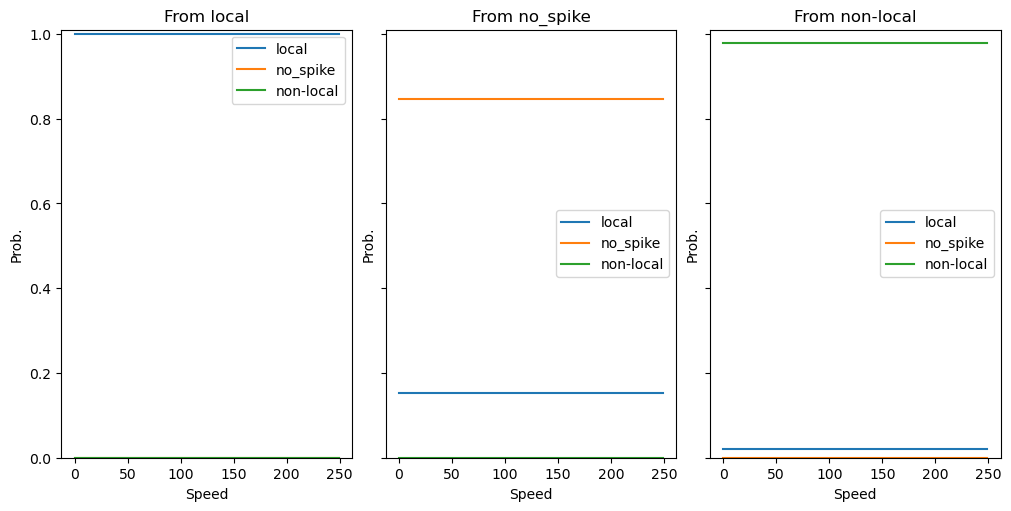

In [4]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward
import matplotlib.pyplot as plt

predict_data = {"speed": np.arange(0, 250.0)}
predict_matrix = build_design_matrices(
    [discrete_transition_design_matrix.design_info], predict_data
)[0]


fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
    from_local_transition = centered_softmax_forward(
        predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
    )

    ax.plot(predict_data["speed"], from_local_transition)
    ax.set_xlabel("Speed")
    ax.set_ylabel("Prob.")
    ax.legend(state_names)
    ax.set_title(f"From {from_state}")

plt.ylim((0, 1.01))


In [5]:
discrete_state_transitions[0]

array([[9.99538829e-01, 4.52128622e-06, 4.56649908e-04],
       [5.00000000e-04, 9.99000000e-01, 5.00000000e-04],
       [2.02831610e-02, 1.00000000e-16, 9.79716839e-01]])

In [6]:
import numpy as np
log_likelihood = np.load("log_likelihood.npy")

Parameters that worked
regularization: 0.001, stickiness: 100,000

In [7]:
from src.test_non_local_switching_non_stationary_model import fit_switching_model

stickiness = np.zeros((3,1))
stickiness[0] = 65
stickiness[1] = 100_000
stickiness[2] = 65

(
    predicted_state,
    acausal_posterior,
    acausal_state_probabilities,
    causal_posterior,
    marginal_log_likelihoods,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    non_local_rates,
) = fit_switching_model(
    spikes,
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    continuous_state_transitions,
    state_ind,
    zero_rates,
    is_training,
    env,
    discrete_transition_coefficients=discrete_transition_coefficients,
    discrete_transition_design_matrix=discrete_transition_design_matrix,
    max_iter=20,
    fit_inital_conditions=True,
    fit_discrete_transition=True,
    fit_likelihood=False,
    is_no_spike_transition_constant=False,
    concentration=1.0,
    stickiness=stickiness,
    log_likelihood=log_likelihood,
    transition_regularization=0.0001,
)


[[[9.99538829e-01 4.52128622e-06 4.56649908e-04]
  [5.00000000e-04 9.99000000e-01 5.00000000e-04]
  [2.02831610e-02 1.00000000e-16 9.79716839e-01]]

 [[9.99538829e-01 4.52128622e-06 4.56649908e-04]
  [5.00000000e-04 9.99000000e-01 5.00000000e-04]
  [2.02831610e-02 1.00000000e-16 9.79716839e-01]]

 [[9.99538829e-01 4.52128622e-06 4.56649908e-04]
  [5.00000000e-04 9.99000000e-01 5.00000000e-04]
  [2.02831610e-02 1.00000000e-16 9.79716839e-01]]

 ...

 [[9.99538829e-01 4.52128622e-06 4.56649908e-04]
  [5.00000000e-04 9.99000000e-01 5.00000000e-04]
  [2.02831610e-02 1.00000000e-16 9.79716839e-01]]

 [[9.99538829e-01 4.52128622e-06 4.56649908e-04]
  [5.00000000e-04 9.99000000e-01 5.00000000e-04]
  [2.02831610e-02 1.00000000e-16 9.79716839e-01]]

 [[9.99538829e-01 4.52128622e-06 4.56649908e-04]
  [5.00000000e-04 9.99000000e-01 5.00000000e-04]
  [2.02831610e-02 1.00000000e-16 9.79716839e-01]]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 1, likelihood: -1908450.3824511496
[[

In [8]:
non_local_rates = np.load("non_local_rates.npy")

(0.0, 10000.0)

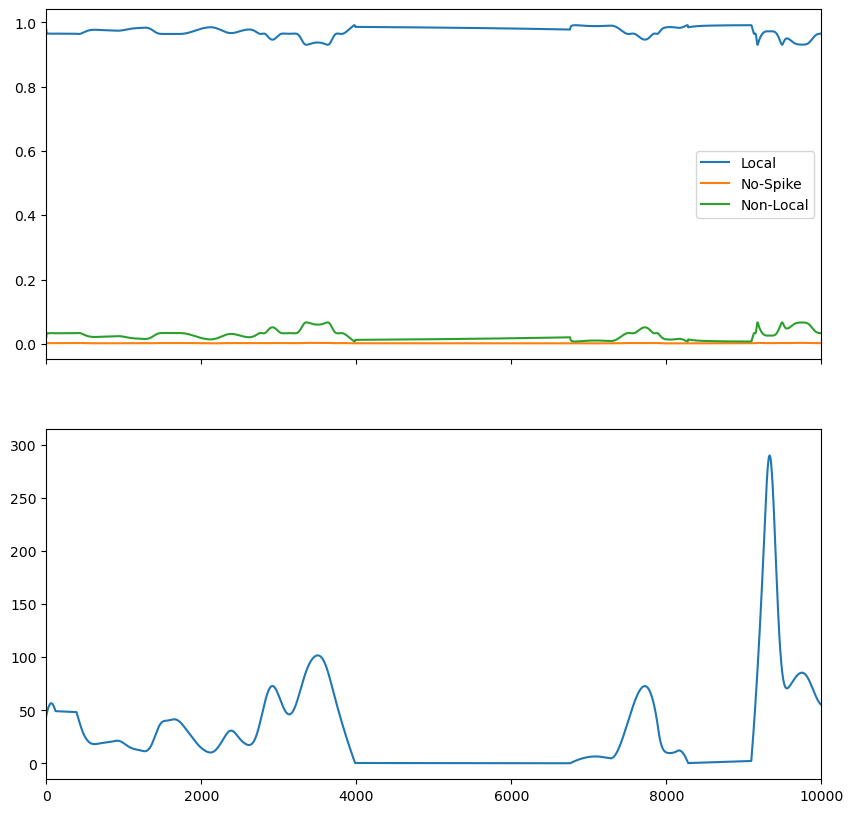

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axes[0].plot(discrete_state_transitions[:, 0, 0], label="Local")
axes[0].plot(discrete_state_transitions[:, 0, 1], label="No-Spike")
axes[0].plot(discrete_state_transitions[:, 0, 2], label="Non-Local")
axes[0].legend()
axes[1].plot(speed)
plt.xlim((0, 10_000))


(100000.0, 110000.0)

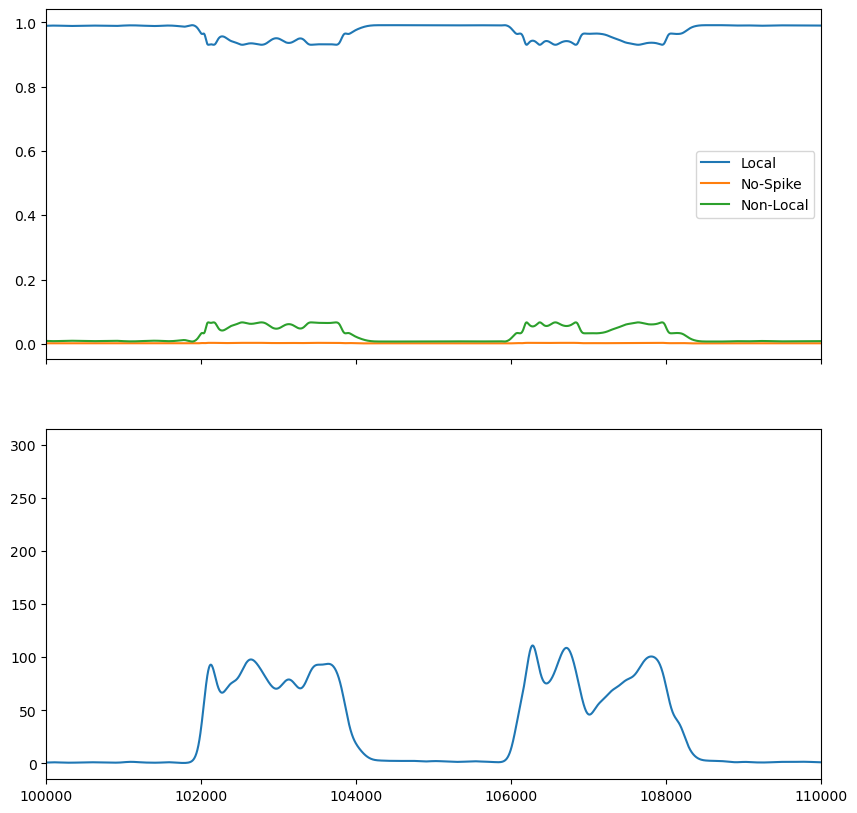

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axes[0].plot(discrete_state_transitions[:, 0, 0], label="Local")
axes[0].plot(discrete_state_transitions[:, 0, 1], label="No-Spike")
axes[0].plot(discrete_state_transitions[:, 0, 2], label="Non-Local")
axes[0].legend()
axes[1].plot(speed)
plt.xlim((100_000, 110_000))


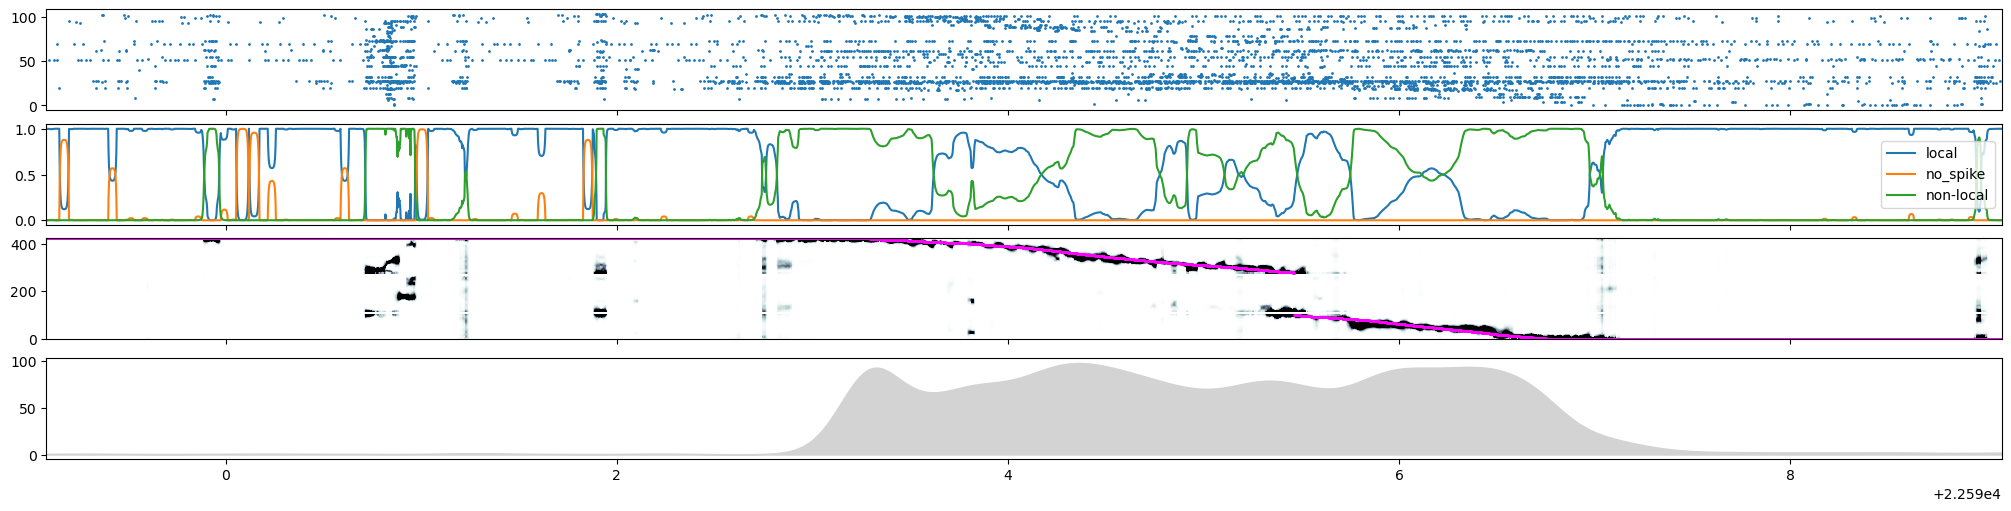

In [11]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(100_000, 105_000),
)


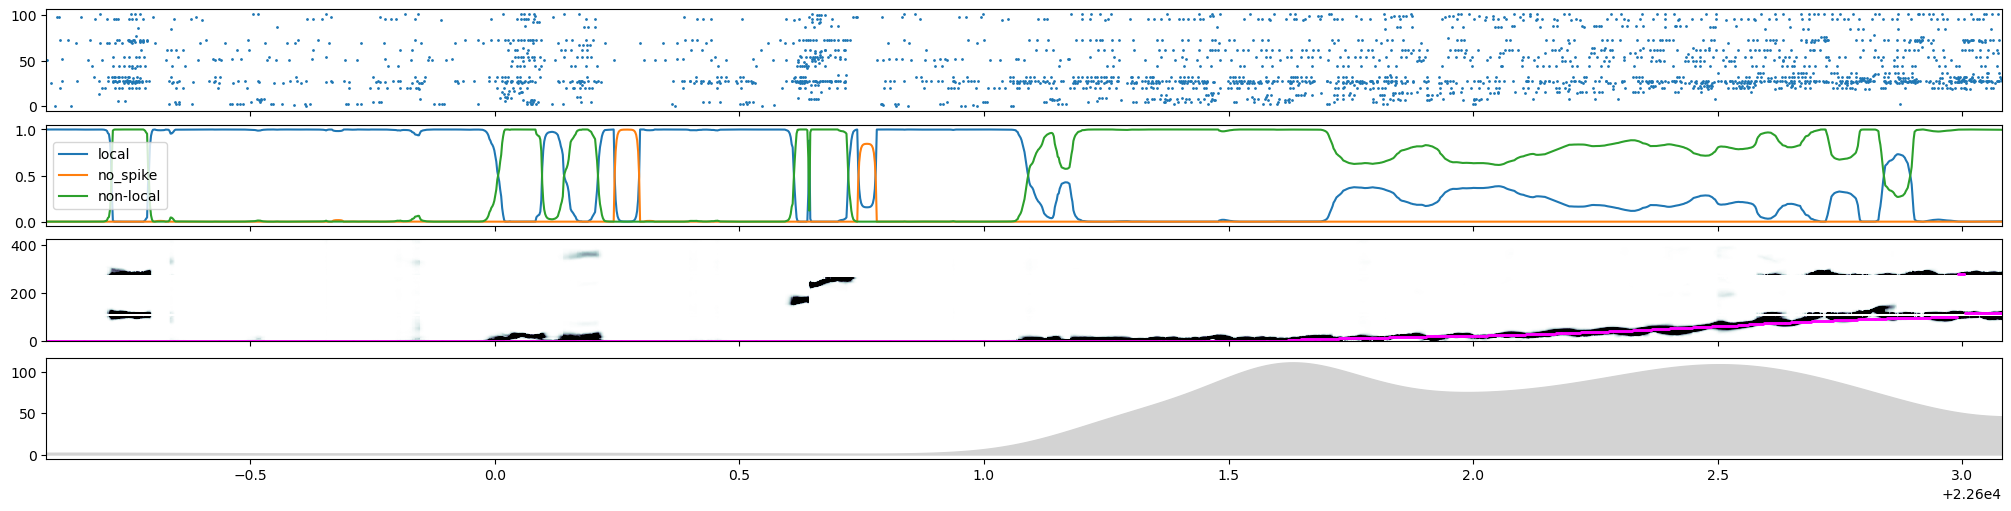

In [12]:
plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(105_000, 107_000),
)


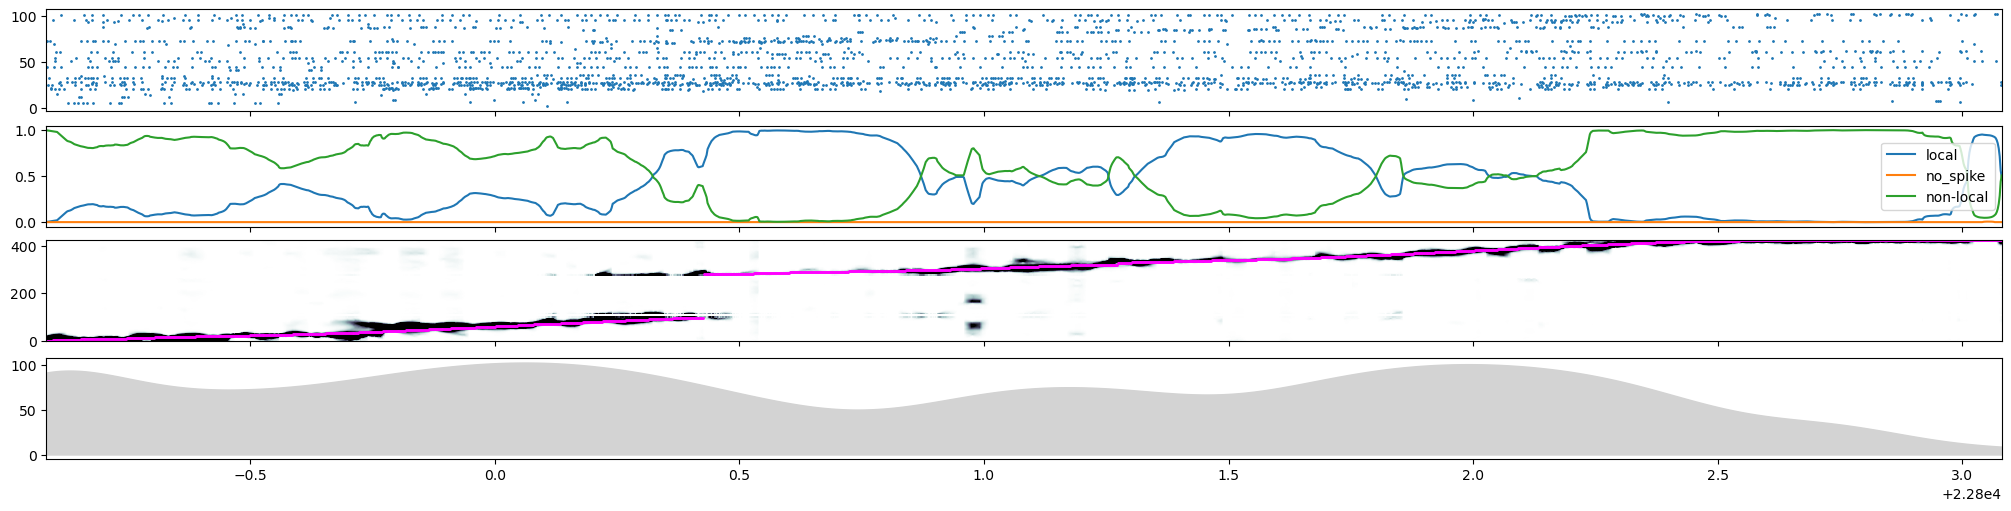

In [13]:
plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(205_000, 207_000),
)


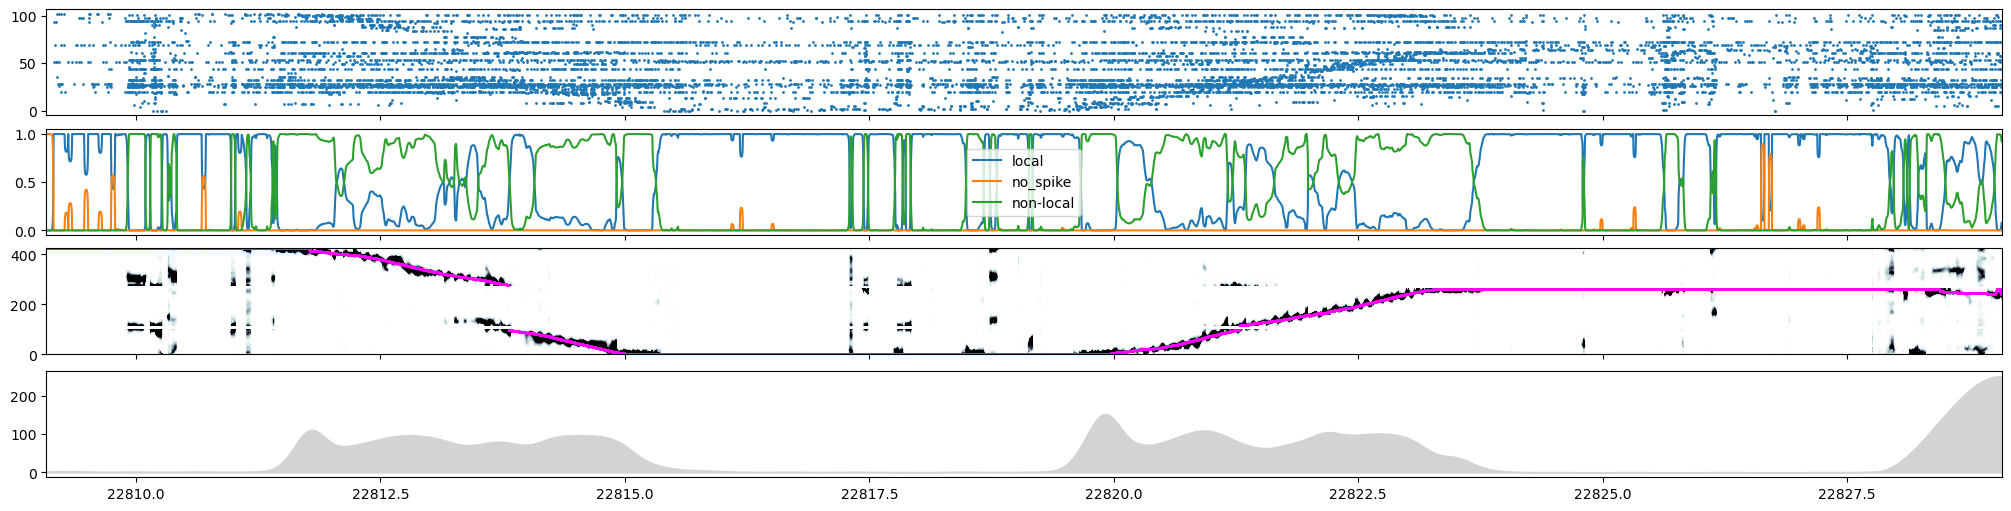

In [14]:
plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(210_000, 220_000),
)


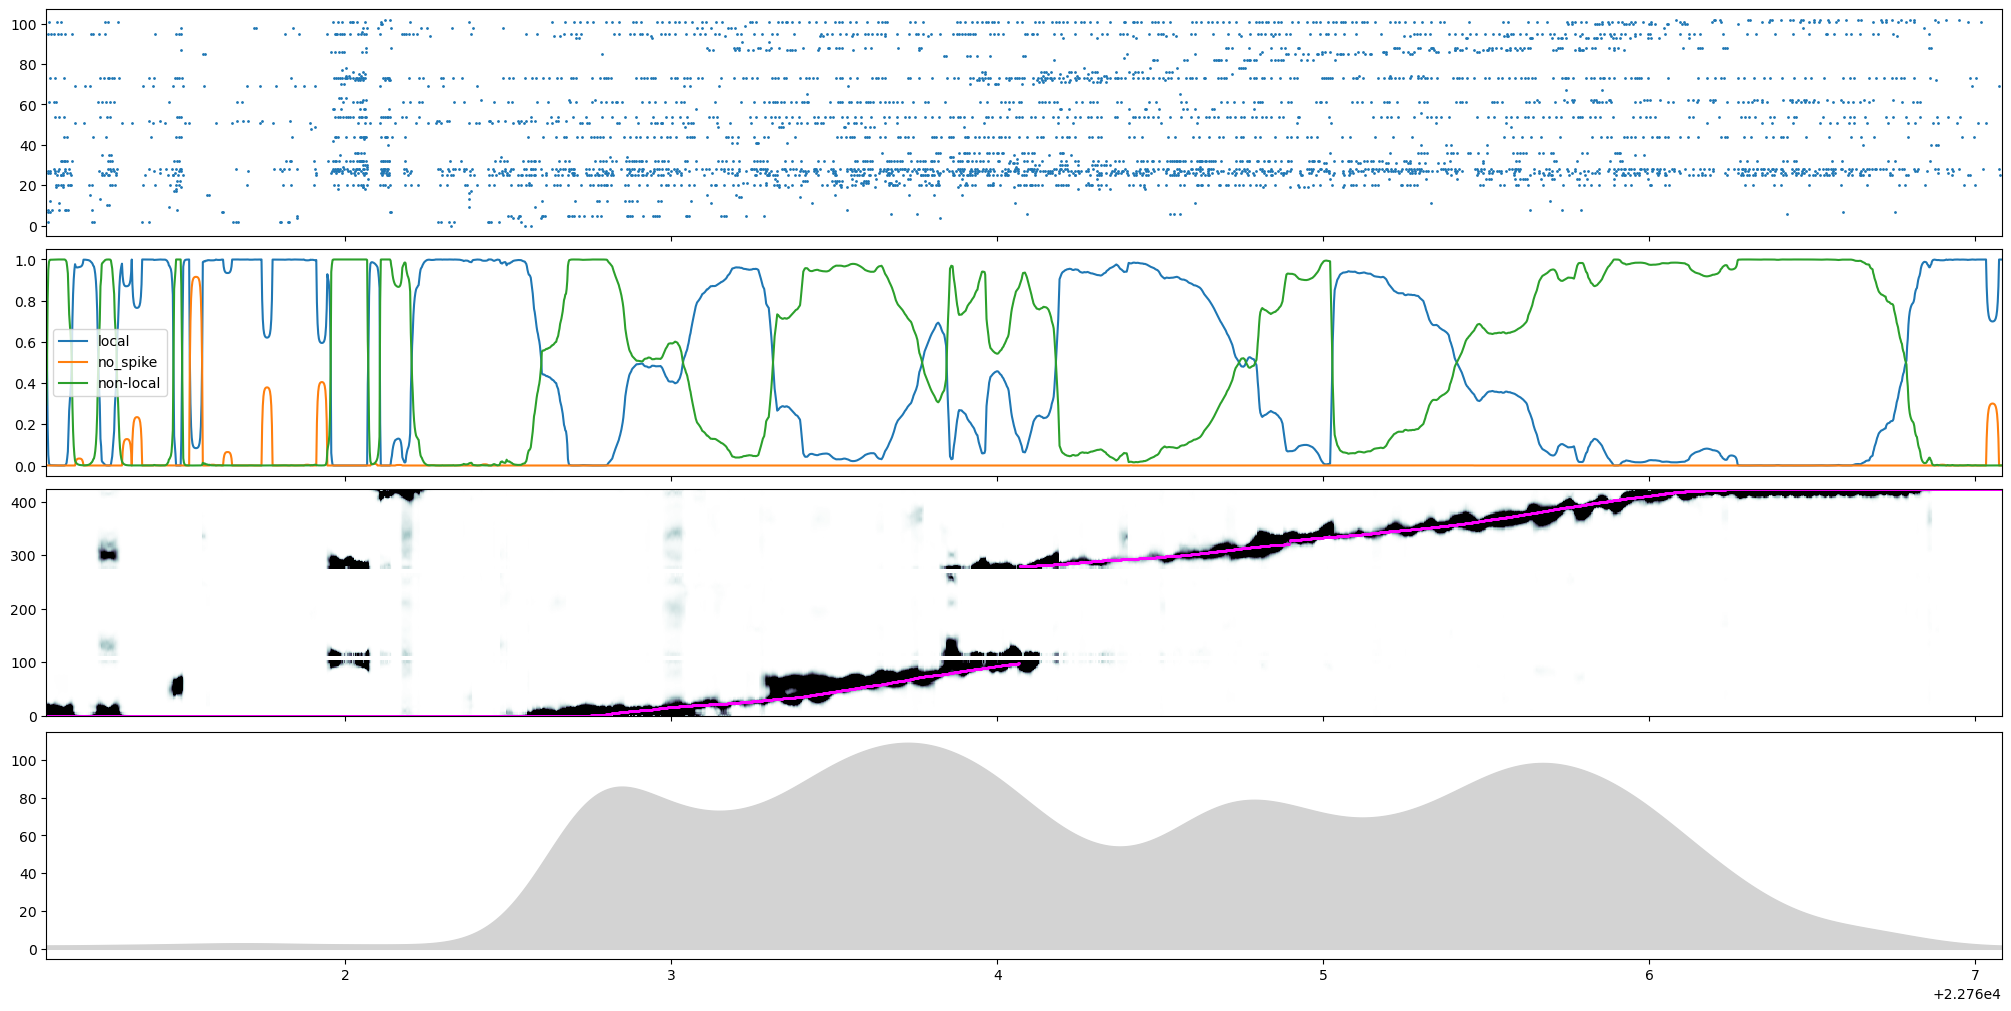

In [15]:
plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(186_000, 189_000),
    figsize=(20, 10),
)


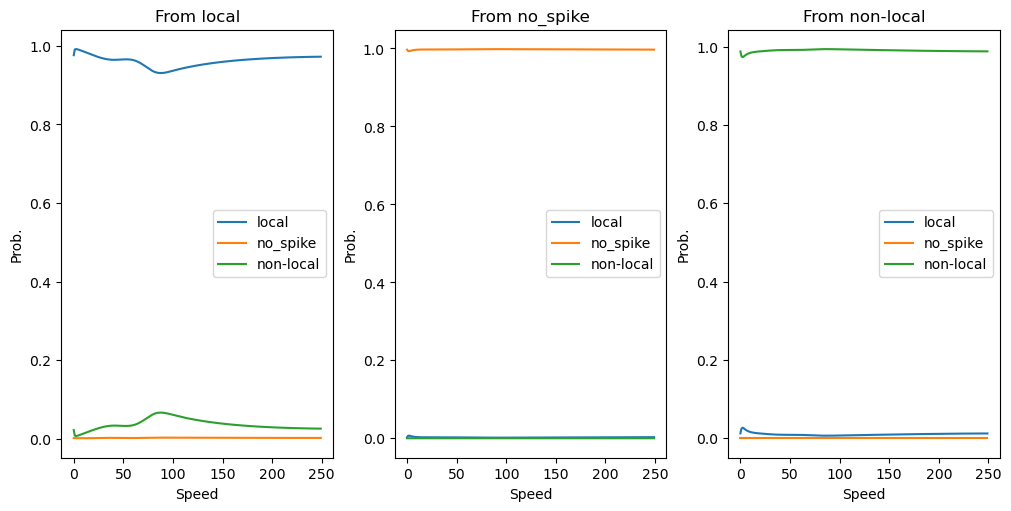

In [16]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward

predict_data = {"speed": np.arange(0, 250.0)}
predict_matrix = build_design_matrices(
    [discrete_transition_design_matrix.design_info], predict_data
)[0]


fig, axes = plt.subplots(1, 3, sharex=True, constrained_layout=True, figsize=(10, 5))

for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
    from_local_transition = centered_softmax_forward(
        predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
    )

    ax.plot(predict_data["speed"], from_local_transition)
    ax.set_xlabel("Speed")
    ax.set_ylabel("Prob.")
    ax.legend(state_names)
    ax.set_title(f"From {from_state}")
